## Basic setup

In [4]:
%matplotlib inline
%run env_setup.py
from __future__ import division,print_function
from importlib import reload
import numpy as np
import os
import sys
from glob import glob
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import lessdeep.utils.display as dis
from lessdeep.utils import save_array, load_array

Using TensorFlow backend.


In [5]:
import pandas as pd
import scipy
pd.DataFrame([keras.__version__, tf.__version__, np.__version__, sys.version.split(' ')[0], scipy.__version__], 
             index=['keras', 'tensorflow', 'numpy', 'python', 'scipy'],
             columns=['Version'])

,Version
keras,2.0.9
tensorflow,1.4.0
numpy,1.13.3
python,3.5.4
scipy,1.0.0


## Download and setup

**you can change the data and the batch size to fit the model to other datasets**

In [6]:
# Download
from lessdeep.datasets import kaggle
reload(kaggle)
train_path, valid_path = kaggle.get_train('dogs-vs-cats', validation=0.3)
test_path = kaggle.get_test('dogs-vs-cats')
## setup working data path
#path = datapath
#sample_path = os.path.join(path, 'sample')

D:\learn\online_course\notes\_data\kaggle\dogs-vs-cats\_cache\down\train.zip already downloaded !
D:\learn\online_course\notes\_data\kaggle\dogs-vs-cats\_cache\down\test1.zip already downloaded !


In [7]:
## As large as you can, but no larger than 64 is recommanded
batch_size = 64

## Load model

In [8]:
# Generate vgg model
import lessdeep.model.vgg16n
reload(lessdeep.model.vgg16n)
from lessdeep.model.vgg16n import Vgg16N

# get batch labels
def onehot(batch_classes):
    from sklearn.preprocessing import OneHotEncoder
    return np.array(OneHotEncoder().fit_transform(batch_classes.reshape(-1, 1)).todense())

## Load data(Batches)
- accept data path contain at least two folder
    - train
    - valid
- each subfolder contain images in each folder with the class name

In [9]:
# depends on the variable datapath
def load_batches(vgg_model):
    batches = vgg_model.get_batches(train_path, batch_size=batch_size)
    val_batches = vgg_model.get_batches(valid_path, batch_size=batch_size)

    # batches in same order of data folder, for debug purpose
    pred_batches = vgg_model.get_batches(valid_path, batch_size=batch_size, shuffle=False)
    pred_onehot = onehot(pred_batches.classes)
    return batches, val_batches, pred_batches, pred_onehot

## Simple Finetune

In [34]:
K.clear_session()
vgg = Vgg16N()
vgg.model.layers.pop()
for layer in vgg.model.layers:
    layer.trainable = False
vgg.model.add(keras.layers.Dense(1000, activation='relu'))
vgg.model.add(keras.layers.Dense(2, activation='softmax'))
vgg.compile()
vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [35]:
batches, val_batches, pred_batches, pred_onehot = load_batches(vgg)
vgg.model.input_shape

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


(None, 224, 224, 3)

## Test on sample

In [11]:
smp_batches = vgg.get_batches(os.path.join(sample_path, 'train'), batch_size=batch_size)
smp_val_batches = vgg.get_batches(os.path.join(sample_path, 'valid'), batch_size=batch_size)
smp_imgs, smp_labels = smp_val_batches.next()

Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


Epoch 1/1
1/1 [==============================] - 3s - loss: 1.7849 - acc: 0.5000 - val_loss: 5.5880 - val_acc: 0.5000


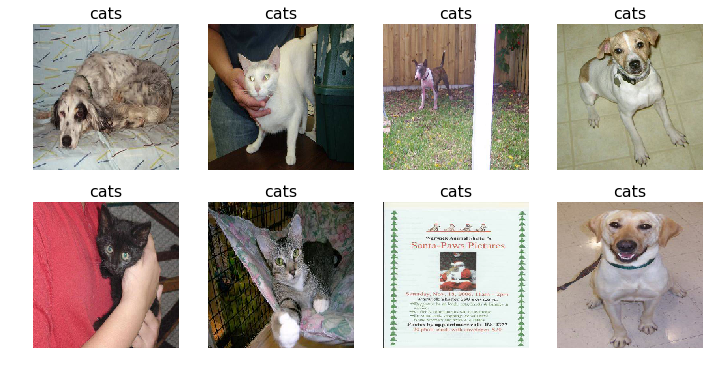

In [12]:
sample_num = 8
sample_epochs = 1

vgg.fit(smp_batches, smp_val_batches, epochs=sample_epochs)

preds, idxs, classes = vgg.predict_data(smp_imgs[:sample_num])
dis.imshow(Vgg16.img_cvt(smp_imgs[:sample_num]), titles=classes[:sample_num], rows=2)

In [36]:
vgg.load_weights('fintune_no_drop.h5')
#vgg.compile(lr=0.00001)
#keras.backend.set_value(vgg.model.optimizer.lr, 0.0001)

## Start train

In [ ]:
epochs = 2
vgg.fit(batches, val_batches, epochs=epochs, workers=4)

In [37]:
# Then try predict and debug
pred_batches.reset()
pred_list = vgg.predict(pred_batches)
preds, classes, probs = zip(*pred_list)
preds = np.array(preds)
probs = np.array(probs)

117/117 [==============================] - 36s 304ms/step


In [15]:
vgg.save_weights('fintune_no_drop.h5')

'D:\\learn\\online_course\\notes\\_model\\vgg16n\\weights\\fintune_no_drop.h5'

## Bad result

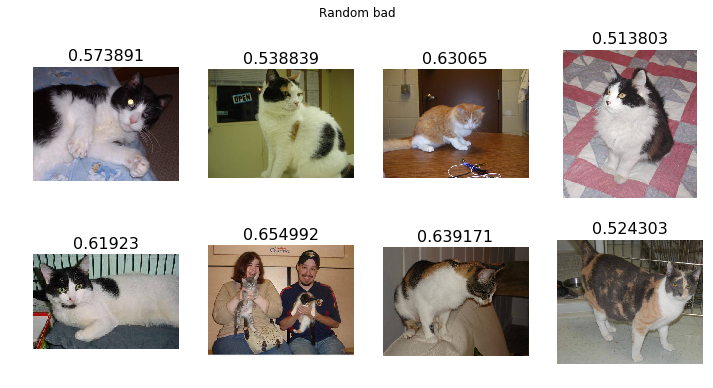

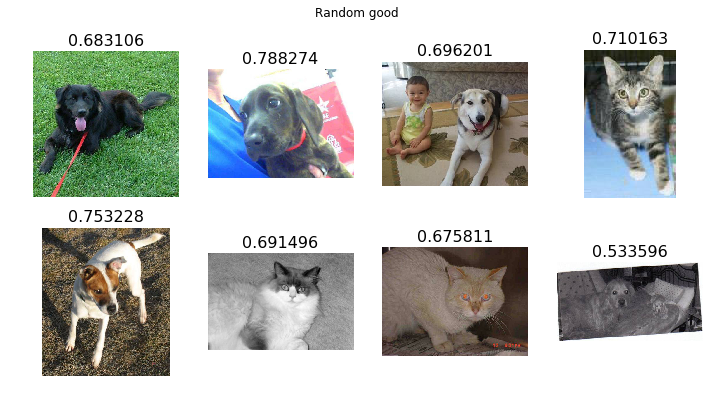

In [72]:
reload(dis)
def show_predict(select, shape, probs, **kwargs):
    from keras.preprocessing.image import load_img

    dis.imshow([load_img(os.path.join(pred_batches.directory, pred_batches.filenames[i])) for i in select],
               titles=np.array(probs)[select], rows=shape[0], **kwargs);

def show_random(preds, probs, res, class_idx=None, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    assert res in ['bad', 'good']
    if class_idx is None:
        title = 'Random ' + res
        if res == 'bad':
            idxes = np.where(np.array(preds[:num]) != pred_batches.classes[:num])[0]
        else:
            idxes = np.where(np.array(preds[:num]) == pred_batches.classes[:num])[0]
    else:
        title = 'Predicted as {class_name} but is not(in random)'.format(class_name=vgg.classes[class_idx])
        if res == 'bad':
            idxes = np.where((np.array(preds[:num]) == class_idx) & (pred_onehot[:num, class_idx] != 1))[0]
        else:
            idxes = np.where((np.array(preds[:num]) == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = np.random.choice(idxes, min(shape[0]*shape[1], len(idxes)), replace=False)
    
    show_predict(select, shape=shape, top_title=title, probs=probs);
    
show_random(preds, probs, 'bad')
show_random(preds, probs, 'good')

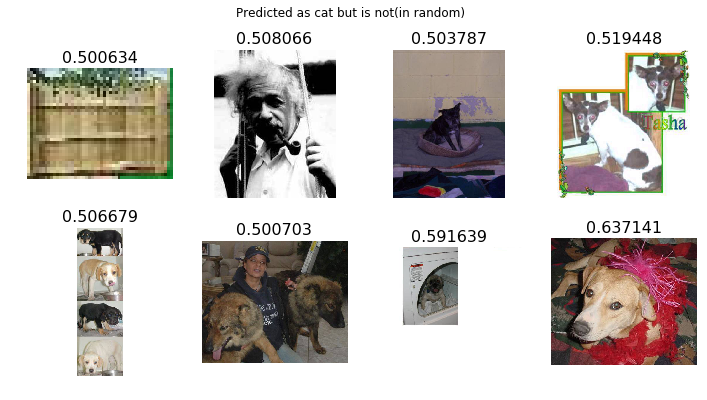

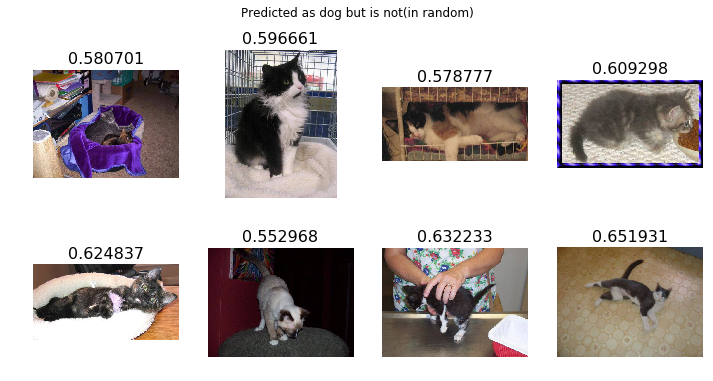

In [73]:
show_random(preds, probs, 'bad', 0)
show_random(preds, probs, 'bad', 1)

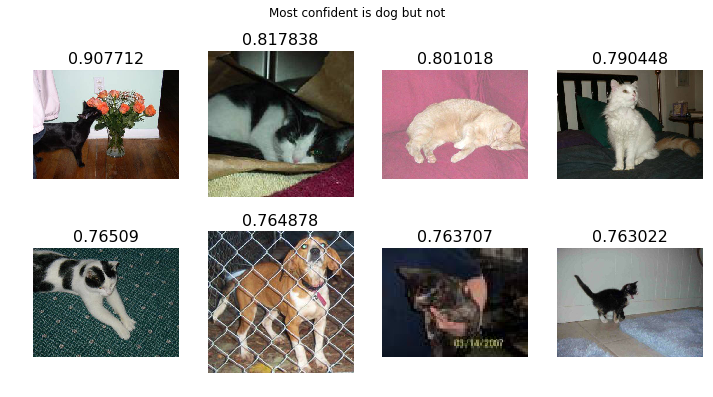

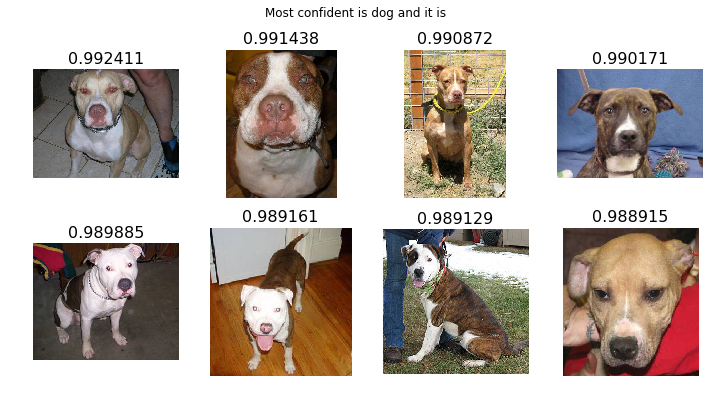

In [74]:
def show_most_confidence(preds, probs, res, class_idx, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    preds, probs = np.array(preds), np.array(probs)
    assert res in ['bad', 'good']
    if res == 'bad':
        title = 'Most confident is {class_name} but not'.format(class_name=vgg.classes[class_idx])
        idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] != 1))[0]
    else:
        title = 'Most confident is {class_name} and it is '.format(class_name=vgg.classes[class_idx])
        idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = idxes[np.argsort(np.array(probs)[idxes])[::-1][:min(shape[0]*shape[1], len(idxes))]]
    
    show_predict(select, shape=shape, top_title=title, probs=probs)
show_most_confidence(preds, probs, 'bad', 1)
show_most_confidence(preds, probs, 'good', 1)

## Most uncertain

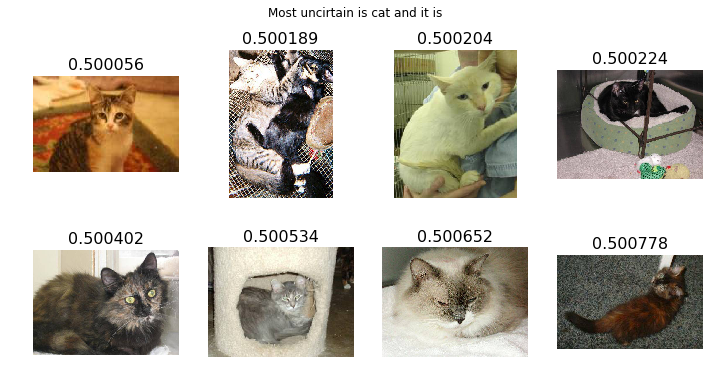

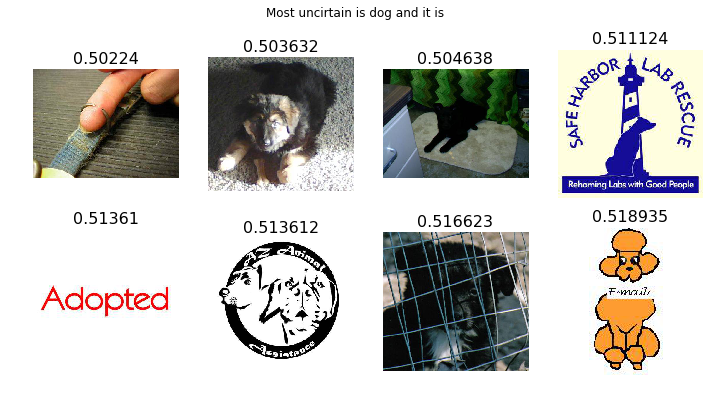

In [75]:
def show_most_uncertain(preds, probs, class_idx, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    preds, probs = np.array(preds), np.array(probs)
    title = 'Most uncirtain is {class_name} and it is '.format(class_name=vgg.classes[class_idx])
    idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = idxes[np.argsort(np.array(probs)[idxes])[:min(shape[0]*shape[1], len(idxes))]]

    show_predict(select, shape=shape, top_title=title, probs=probs)
show_most_uncertain(preds, probs, 0)
show_most_uncertain(preds, probs, 1)

In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_batches.classes[:len(preds)], preds)
print(cm)

[[3067  683]
 [  11 3727]]


# Submit result

In [3]:
#test_batches = vgg.get_batches(os.path.join(datapath, 'test'), batch_size=batch_size, shuffle=False)
def save_test(test_preds, class_idx, test_files,clip=0.02):
    import csv
    file = os.path.join('_cache', 'submit.csv')
    with open(file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['id', 'label'])
        clipped = np.clip(test_preds, clip, 1-clip)
        for i, pred in enumerate(clipped):
            source_name = os.path.basename(test_files[i])
            writer.writerow([os.path.splitext(source_name)[0], pred[class_idx]])
    return file

In [ ]:
steps = int(np.ceil(test_batches.samples / test_batches.batch_size))
test_batches.reset()
test_preds = vgg.model.predict_generator(test_batches, steps=steps, verbose=1)[:test_batches.samples]
from IPython.display import FileLink
FileLink(save_test(test_preds, class_idx=1), )

# Train better
- Underfitting
    - Less Dropout
- Overfitting
    - Add more data, e.g. Data augmentation
    - More generalize architecture
    - Regularization,e.g. Normalize input, Batch Norm
    - Reduce architecture complexity
- Improve train performance
    - Save convolutional layers

## Add Dropout

In [14]:
K.clear_session()
vgg = Vgg16N(dropout=0.5)
vgg.model.layers.pop()
for layer in vgg.model.layers:
    layer.trainable = False
vgg.model.add(keras.layers.Dense(1000, activation='relu'))
vgg.model.add(keras.layers.Dense(2, activation='softmax'))
vgg.compile()
vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
batches, val_batches, pred_batches, pred_onehot = load_batches(vgg)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [16]:
epochs = 2
vgg.fit(batches, val_batches, epochs=epochs, workers=2)

Epoch 1/2
273/273 [==============================] - 124s 454ms/step - loss: 0.1608 - acc: 0.9670 - val_loss: 0.1138 - val_acc: 0.9746
Epoch 2/2
273/273 [==============================] - 124s 454ms/step - loss: 0.1071 - acc: 0.9764 - val_loss: 0.0756 - val_acc: 0.9837


## Save convolutional layers

In [12]:
K.clear_session()
vgg_conv = Vgg16N(include_top=False)

In [13]:
conv_img_batches = vgg_conv.get_batches(train_path, batch_size=batch_size, shuffle=False)
conv_img_val_batches = vgg_conv.get_batches(valid_path, batch_size=batch_size, shuffle=False)
conv_test_batches = vgg_conv.get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [14]:
%pdb

Automatic pdb calling has been turned ON


In [62]:
reload(lessdeep.utils)
reload(lessdeep.model.vgg16n)
from lessdeep.model.vgg16n import Vgg16N

In [15]:
vgg_conv.save_predict(conv_img_batches, 'vgg_train_feature')
vgg_conv.save_predict(conv_img_val_batches, 'vgg_val_feature')
vgg_conv.save_predict(conv_test_batches, 'vgg_test_feature', save_label=False)

100% (14 of 14) |#########################| Elapsed Time: 0:02:10 Time: 0:02:10
100% (6 of 6) |###########################| Elapsed Time: 0:00:54 Time: 0:00:54
100% (10 of 10) |#########################| Elapsed Time: 0:01:23 Time: 0:01:23


In [11]:
test_files_cache = '_cache/dog-vs-cat/test_files.pkl'

In [1]:
import pickle
os.makedirs(os.path.dirname(test_files_cache), exist_ok=True)
with open(test_files_cache, 'wb') as f:
    pickle.dump(conv_test_batches.filenames, f)

## Load cached features

In [12]:
train_features,train_labels = Vgg16N.get_predict_batch('vgg_train_feature')
val_features,val_labels = Vgg16N.get_predict_batch('vgg_val_feature')
test_features = Vgg16N.get_predict_batch('vgg_test_feature')
with open(test_files_cache, 'rb') as f:
    test_files = pickle.load(f)

## Start with only top layers

In [14]:
# Remove drop out
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D
def fit_feature(model, batch_size, epochs):
    model.fit(train_features, train_labels, batch_size=batch_size, epochs=epochs,
              validation_data=(val_features, val_labels), shuffle=True)

In [26]:
K.clear_session()
dense_model_0 = Vgg16N().get_top_layers(clone=True)
dense_model_0.pop()
dense_model_0.add(Dense(2, activation='softmax'))
from keras.optimizers import Adam
opt = Adam(lr=0.001)
dense_model_0.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
dense_model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8194      
Total params: 119,554,050
Trainable params: 8,194
Non-trainable params: 119,545,856
_________________________________________________________________


In [27]:
# Train
fit_feature(dense_model_0, batch_size=128, epochs=3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 9s 498us/step - loss: 0.0763 - acc: 0.9736 - val_loss: 0.0447 - val_acc: 0.9840
Epoch 2/3
17500/17500 [==============================] - 8s 451us/step - loss: 0.0397 - acc: 0.9862 - val_loss: 0.0461 - val_acc: 0.9831
Epoch 3/3
17500/17500 [==============================] - 8s 451us/step - loss: 0.0263 - acc: 0.9905 - val_loss: 0.0490 - val_acc: 0.9809


In [38]:
# add more trainable(last three dense)
K.clear_session()
dense_model_1 = Vgg16N(dropout=0.5).get_top_layers(clone=True, trainable=False)
dense_model_1.pop()
dense_model_1.add(Dense(2, activation='softmax'))
from keras.optimizers import Adam
opt = Adam(lr=0.001)
dense_model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
dense_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8194      
Total para

In [39]:
#K.set_value(opt.lr, 0.0001)
fit_feature(dense_model_1, batch_size=64, epochs=1)
for l in dense_model_1.layers:
    l.trainable = True
K.set_value(opt.lr, 0.00001)
dense_model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
fit_feature(dense_model_1, batch_size=64, epochs=1)

Train on 17500 samples, validate on 7500 samples
Epoch 1/1
17500/17500 [==============================] - 10s 558us/step - loss: 0.3314 - acc: 0.9643 - val_loss: 0.2079 - val_acc: 0.9789
Train on 17500 samples, validate on 7500 samples
Epoch 1/1
17500/17500 [==============================] - 31s 2ms/step - loss: 0.2189 - acc: 0.9798 - val_loss: 0.1211 - val_acc: 0.9871


In [40]:
fit_feature(dense_model_1, batch_size=64, epochs=2)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 30s 2ms/step - loss: 0.1287 - acc: 0.9877 - val_loss: 0.1095 - val_acc: 0.9876
Epoch 2/2
17500/17500 [==============================] - 30s 2ms/step - loss: 0.0802 - acc: 0.9916 - val_loss: 0.1071 - val_acc: 0.9873


In [41]:
dense_model_1.save_weights('dense1.h5')

In [15]:
# add batch normal
from keras.layers import BatchNormalization
K.clear_session()
dense_model_2 = Vgg16N().get_top_layers(dense_num=1, clone=True, trainable=False)
dense_model_2.add(BatchNormalization())
dense_model_2.add(Dense(4096, activation='relu'))
dense_model_2.add(BatchNormalization())
dense_model_2.add(Dense(2, activation='softmax'))
from keras.optimizers import Adam
opt = Adam(lr=0.0001)
dense_model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
dense_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8194      
Total para

In [21]:
K.set_value(opt.lr, 0.0001)
fit_feature(dense_model_2, batch_size=128, epochs=2)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 10s 550us/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.0702 - val_acc: 0.9863
Epoch 2/2
17500/17500 [==============================] - 10s 548us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0707 - val_acc: 0.9856


In [21]:
dense_model_2.save_weights('_cache/batchnorm_only.h5')

In [16]:
dense_model_2.load_weights('_cache/batchnorm_only.h5')

In [22]:
test_preds = dense_model_2.predict(test_features, batch_size=64, verbose=1)
from IPython.display import FileLink
FileLink(save_test(test_preds, class_idx=1, test_files=test_files), )

12500/12500 [==============================] - 5s 381us/step


D:\learn\online_course\notes\lessdeep\note_tpl\_cache\submit.csv